In [1]:
from sklearn.datasets import load_files       
from tensorflow.keras.utils import to_categorical
import numpy as np
from globals import dog_data_dir
import os
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_set_path = os.path.join(dog_data_dir, 'train')
train_files, train_targets = load_dataset(train_set_path)
valid_files, valid_targets = load_dataset(os.path.join(dog_data_dir, 'valid'))
test_files, test_targets = load_dataset(os.path.join(dog_data_dir, 'test'))

# load list of dog names
dog_names = [item[5:] for item in sorted(glob(os.path.join(train_set_path, '*')))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
from globals import faces_data_dir
import random

human_files = np.array(glob(os.path.join(faces_data_dir, '*', '*')))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [3]:
import pandas as pd
breed_count = {}
for file in train_files:
    breed = file.split('.')[-2].split('/')[0]
    if breed not in breed_count:
        breed_count[breed] = 1
    else:
        breed_count[breed] += 1

        
breed_count_df = pd.DataFrame(list(breed_count.items()), columns=['Breed', 'Count'])
breed_count_df = breed_count_df.sort_values('Count')
breed_count_df

,Breed,Count
53,Xoloitzcuintli,26
119,Norwegian_buhund,26
33,Plott,28
28,Manchester_terrier,29
117,Smooth_fox_terrier,30
...,...,...
25,Bull_terrier,69
1,Dalmatian,71
11,Basset_hound,73
106,Border_collie,74


In [4]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet')
detector_model = ResNet50(weights='imagenet')

In [5]:
from tensorflow.keras.preprocessing import image                  

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

detector_model = ResNet50(weights='imagenet')

def is_dog(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    prediction = np.argmax(detector_model.predict(img))
    return ((prediction <= 268) & (prediction >= 151)) 

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

In [8]:
dogs_in_human_files_short = []
dogs_in_dog_files_short = []

for h_file, d_file in zip(human_files_short, dog_files_short):
    dog_in_human = is_dog(h_file)
    dogs_in_human_files_short.append(dog_in_human)
    
    dog_in_dog = is_dog(d_file)
    dogs_in_dog_files_short.append(dog_in_dog)

print('Proportion of dogs detected by dog_dector in human_files_short: ', 
    sum(dogs_in_human_files_short)/len(dogs_in_human_files_short))

print('Proportion of dogs detected by dog_dector in dog_files_short: ', 
    sum(dogs_in_dog_files_short)/len(dogs_in_dog_files_short))

1/1 [==============================] - 0s 60ms/step
Proportion of dogs detected by dog_dector in human_files_short:  0.01
Proportion of dogs detected by dog_dector in dog_files_short:  1.0


In [9]:
from globals import bottleneck_features_dir

bottleneck_features = np.load(os.path.join(bottleneck_features_dir, 'DogResnet50Data.npz'))
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

print(train_Resnet50.shape[1:])

(1, 1, 2048)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
model.add(Dense(133, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 133)               272517    
                                                                 
Total params: 272517 (1.04 MB)
Trainable params: 272517 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [12]:
from globals import saved_models_dir
from datetime import datetime
model_path = os.path.join(saved_models_dir, datetime.today().strftime('%Y%m%d-') + 'best_weights_resnet50.hdf5')

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)

model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
304/334 [==========================>...] - ETA: 0s - loss: 1.7208 - accuracy: 0.5773
Epoch 1: val_loss improved from inf to 0.83273, saving model to /Users/Pranav/Documents/GitHub/Furtographer/model/saved_models/20231205-best_weights_resnet50.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 1.6332 - accuracy: 0.5961 - val_loss: 0.8327 - val_accuracy: 0.7413
Epoch 2/20
116/334 [=========>....................] - ETA: 0s - loss: 0.4450 - accuracy: 0.8694

/Users/Pranav/Documents/GitHub/Furtographer/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312/334 [===========================>..] - ETA: 0s - loss: 0.4489 - accuracy: 0.8583
Epoch 2: val_loss improved from 0.83273 to 0.68806, saving model to /Users/Pranav/Documents/GitHub/Furtographer/model/saved_models/20231205-best_weights_resnet50.hdf5
334/334 [==============================] - 0s 1ms/step - loss: 0.4441 - accuracy: 0.8593 - val_loss: 0.6881 - val_accuracy: 0.7844
Epoch 3/20
301/334 [==========================>...] - ETA: 0s - loss: 0.2680 - accuracy: 0.9143
Epoch 3: val_loss improved from 0.68806 to 0.64526, saving model to /Users/Pranav/Documents/GitHub/Furtographer/model/saved_models/20231205-best_weights_resnet50.hdf5
334/334 [==============================] - 0s 1ms/step - loss: 0.2640 - accuracy: 0.9141 - val_loss: 0.6453 - val_accuracy: 0.8072
Epoch 4/20
334/334 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9412
Epoch 4: val_loss improved from 0.64526 to 0.64282, saving model to /Users/Pranav/Documents/GitHub/Furtographer/model/saved_mod

In [14]:
model.load_weights(model_path)

In [15]:
model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 8ms/step
Test accuracy: 80.2632%


In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

predict_bottle_model = ResNet50(weights='imagenet', include_top=False)

def predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = predict_bottle_model.predict(preprocess_input(path_to_tensor(img_path)))
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [17]:
from IPython.display import Image 

def predict_breed_dog_or_human(img_path):
    display(Image(img_path, width = 300))
    if is_dog(img_path):
        breed = predict_breed(img_path).split('.')[-1]
        print(f'The predicted breed of dog in this image is {breed}')
    else:
        print('no dog in image')

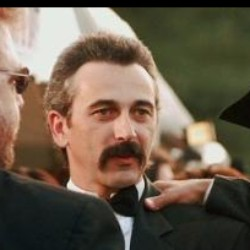

1/1 [==============================] - 0s 83ms/step
no dog in image


In [18]:
predict_breed_dog_or_human('example_images/guy.jpg')

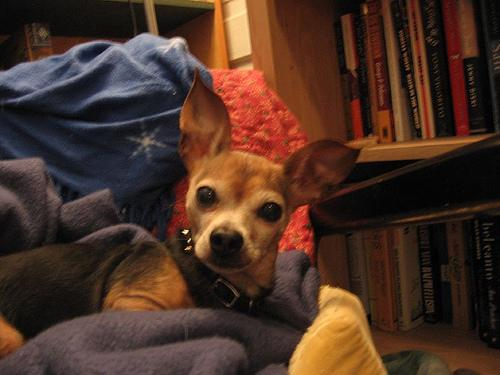

1/1 [==============================] - 0s 16ms/step
The predicted breed of dog in this image is Chihuahua


In [19]:
predict_breed_dog_or_human('example_images/chihuahua.jpg')

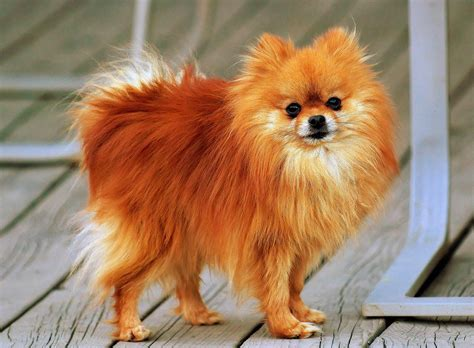

1/1 [==============================] - 0s 8ms/step
The predicted breed of dog in this image is Pomeranian


In [20]:
predict_breed_dog_or_human('example_images/pomeranian.jpg')